# Andor Full Vertical Binning for Resolving Single Photon O2 Fluorescence 

## Intro

Modifications to Data Acquisition (DAQ) system to enable data collection with slow cameras increases the number of configurations that prevent the DAQ from operating.  The goal here is to show that O2 photons can be identified in higher level noise present during full vertical binning by using fourier domain filtering to digitally attenuate the readout noise.

## Loading Libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter

## Initializing Data

### Loading Data

In [274]:
#load data
experiment_run_name = "xpptut15run360.h5"       #this contains
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

### Converting hdf5 to Python Dictionary

In [233]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    try:
        my_dict[i] = array(my_hdf5_object[i])
    except:
        pass

In [234]:
 my_dict['andor/image/orig'] = 0+ my_dict['andor/image']

In [238]:
#removing offsets
my_dict['andor/image'] = my_dict['andor/image/orig'][0]-mean(my_dict['andor/image/orig'][0][:100])
for i in arange(1,len(my_dict['andor/image'])):
    #my_dict['andor/image'][i]=my_dict['andor/image/orig'][i]- mean(my_dict['andor/image/orig'][i][:100])
    my_dict['andor/image'] = vstack([my_dict['andor/image'] ,my_dict['andor/image/orig'][i]-mean(my_dict['andor/image/orig'][i][:100])])

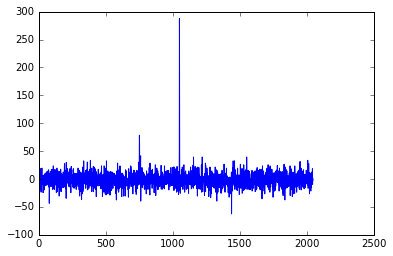

In [239]:
plot(my_dict['andor/image/orig'][100]-mean(my_dict['andor/image/orig'][100][:100]))
show()

## Visualizing Some Sample Data

### some single shots

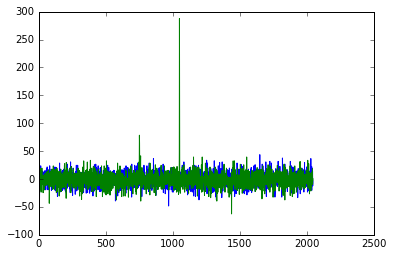

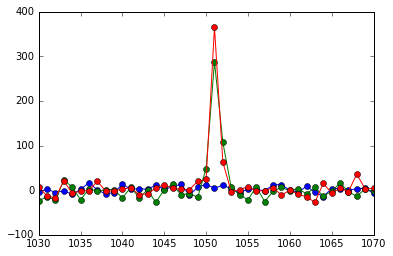

In [240]:
#plot some sample data
plot(my_dict['andor/image'][0])
plot(my_dict['andor/image'][100])
show()
plot(my_dict['andor/image'][0],'o-')
plot(my_dict['andor/image'][100],'o-')
plot(my_dict['andor/image'][200],'o-')
xlim(1030,1070)
show()

## Histogram of photon intensities

### comparing with signal vs thresholded noise

In [241]:
def outlier_removal(y,window_size):
    #smoothed = convolve(y,ones(window_size)*1.0/window_size,mode="same")
    smoothed = medfilt(y,window_size)
    stan_dev = std(y-smoothed)

    to_return = []
    for i in arange(len(y)):
        if (abs(y[i]-smoothed[i])>2.5*stan_dev):
            #to_return.append(smoothed[i])
            to_return.append(-9)
        else:
            to_return.append(y[i])
    return to_return

In [242]:
window_size = 11
my_noise = outlier_removal(my_dict['andor/image'].flatten(),window_size)   #just looking at the noise

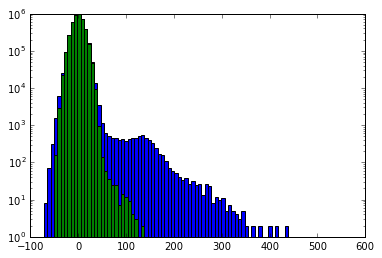

In [244]:
hist(my_dict['andor/image'].flatten(),bins=arange(-100,600,7),log=True)
hist(my_noise,bins=arange(-100,600,7),log=True)
show()

### comparing fourier filtered histogram with regular histogram

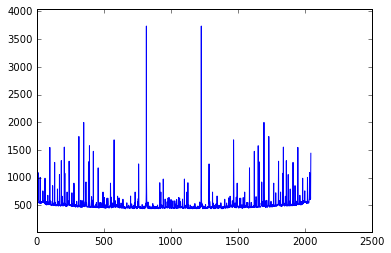

In [245]:
#find location of of largest noise term
my_power_spectrum = mean(abs(fft(my_dict['andor/image'],axis=1)), axis=0)
plot(my_power_spectrum)
ylim(e**3,0.5*e**9)
show()

In [246]:
n_events=1000
fourier_filter_images = fft(my_dict['andor/image'],axis=1)
for i in arange(n_events):
    temp_power_spectrum = mean(abs(fourier_filter_images[:n_events]), axis=0)
    my_arg_max = argmax(temp_power_spectrum)
    my_max = temp_power_spectrum[my_arg_max]
    #print(my_arg_max)
    #print(my_max)
    #print(i)
    
    fourier_filter_images[:,my_arg_max] *=500.0/my_max
    fourier_filter_images[:,len(my_power_spectrum)-my_arg_max-1] *=500.0/my_max

corrected_image = real(ifft(fourier_filter_images,axis=1))


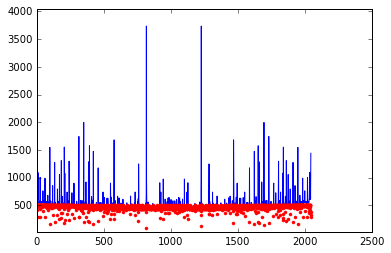

In [248]:
plot(mean(abs(fft(my_dict['andor/image'],axis=1)), axis=0),'b-')
plot(temp_power_spectrum,'r.')
ylim(e**3,0.5*e**9)
show()

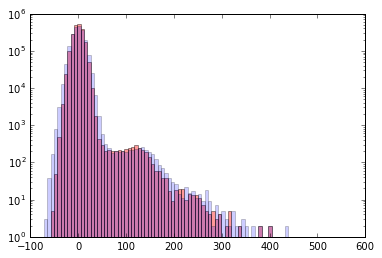

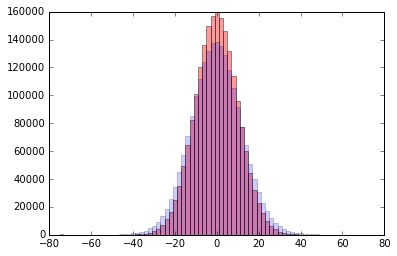

In [268]:
bin_start = -100
bin_end= 600
hist(corrected_image[:n_events].flatten(),bins=arange(bin_start,bin_end,7),log=True,alpha=0.4,color='r')
hist(my_dict['andor/image'][:n_events].flatten(),bins=arange(bin_start,bin_end,7),log=True,alpha=0.2)
show()

hist(corrected_image[:n_events].flatten(),bins=arange(-75,75,2),alpha=0.4,color='r')
hist(my_dict['andor/image'][:n_events].flatten(),bins=arange(-75,75,2),alpha=0.2)

show()


In [273]:
print(std(my_noise))
print(std(outlier_removal(corrected_image[:n_events].flatten(),window_size)))
#print(std(corrected_image[:n_events].flatten()))

11.8214166281
9.95250575571


## comparing effects of thresholding

### Brute Force Sum

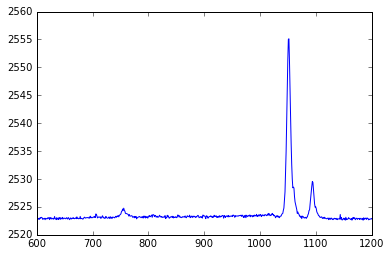

In [22]:
plot(mean(my_dict['andor/image'],axis=0))
xlim(600,1200)
show()

### Thresholded sum

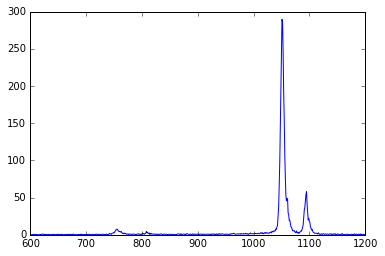

In [21]:
threshold_mask = my_dict['andor/image']<2650
thresholded_data = 0+ my_dict['andor/image']
thresholded_data[threshold_mask]=0
plot(mean(thresholded_data,axis=0))
xlim(600,1200)
show()

### Determining shape of gaussian

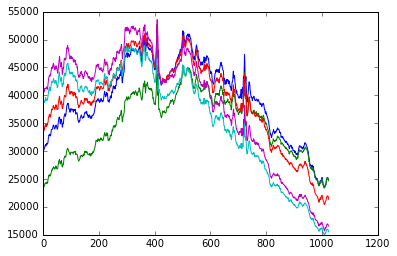

In [5]:
#identify background shots and plot some of them
my_dropped_shots = array(my_dict['evr/code_162']==1)              #this creates an array of booleans for dropped shots
atm_backgrounds = my_dict[time_camera][my_dropped_shots][::10]    #using the boolean array to select the dropped shots
plot(atm_backgrounds[30::400].transpose())
show()

##  Eigen-Backgrounds

### Calculating Eigen Backgrounds Using SVD

In [6]:
#singular value decomposition on background shots. variable v contains the eigen backgrounds
u,s,v = svd(atm_backgrounds) 

### Showing Three Dominant Eigen Backgrounds

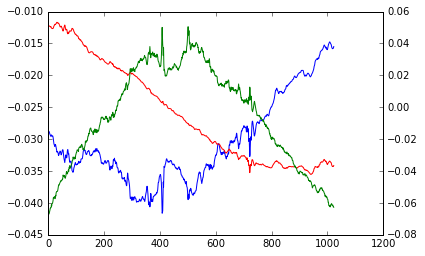

In [7]:
#showing some of the eigen backgrounds
plot(v[0])
twinx()
plot(v[1],'r-')
plot(v[2],'g-')
show()

### Remove the Eigen-Backgrounds from the Data With X-ray Timing Signal

In [8]:
#subtracting the backgrounds from the data
svd_size = 4
background_subtracted = my_dict[time_camera] - dot(dot(my_dict[time_camera],v[:svd_size].transpose()),v[:svd_size])

### Visualizing the Eigen Background Subtracted Timing X-ray Laser Intersection Edge

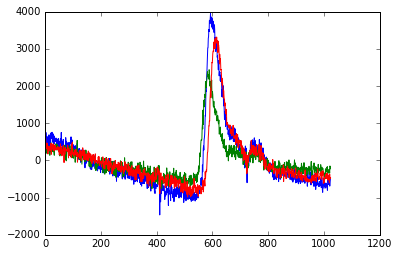

In [9]:
#plotting the background subtracted data
plot(background_subtracted[10])
plot(background_subtracted[2000])
plot(background_subtracted[4000])
show()

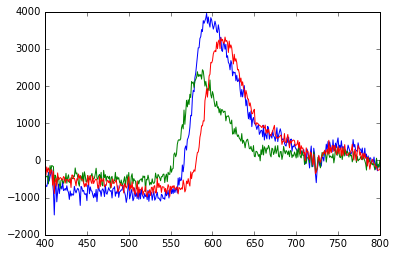

In [10]:
#zooming in
plot(background_subtracted[10])
plot(background_subtracted[2000])
plot(background_subtracted[4000])
xlim(400,800)
show()

## Calculating the Rising Edge Position

The rising edge position is calculated by convolving with a slope 25 pixels wide and finding the max of that slope by fitting a parabola in the vicinity of the local maximum.

In [11]:
recalculated_atm = []
recalculated_atm_cov = []
def peakFunction(x,a,x0,offset):
    return a*(x-x0)**2+offset
for i in arange(len(background_subtracted)):
    filtered_signal = savgol_filter(background_subtracted[i],25,2,1)      #calculates the rolling slope over 25 points
    win_c = argmax(abs(filtered_signal))
    initial_guess = [1,win_c,filtered_signal[win_c]]
    try:
        #fitting peak with a parabola
        popt,pcov = curve_fit(peakFunction,arange(win_c-4,win_c+5),abs(filtered_signal[win_c-4:win_c+5]), p0=initial_guess)


        recalculated_atm.append(popt[1])
        recalculated_atm_cov.append(pcov[1,1])
    except (RuntimeError,ValueError):
        recalculated_atm.append(-999.0)
        recalculated_atm_cov.append(-999.0)
        


Below is a snap shot of the convolution together with where the parabola is fit. The first figure is zoomed out and the second figure is zoomed in.

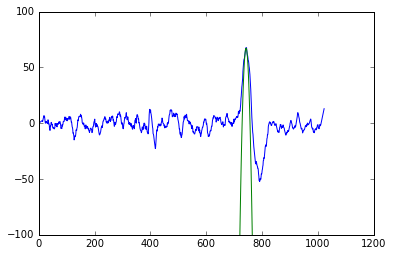

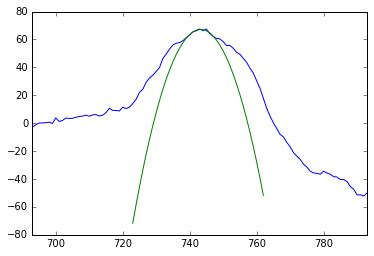

In [12]:
#the filtered_signal is rolling slope over 25 points. instead of convolving with a step function
plot(filtered_signal)
plot(arange(win_c-40,win_c+50),peakFunction(arange(win_c-40,win_c+50),*popt))
ylim(-100,100)
show()
#zooming in
plot(filtered_signal)
window_size = 20
plot(arange(win_c-window_size,win_c+window_size),peakFunction(arange(win_c-window_size,win_c+window_size),*popt))
xlim(win_c-50,win_c+50)
show()


## Histogram of the pixel values for the rising edge

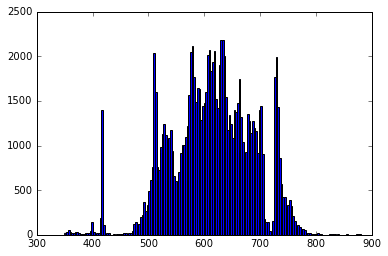

In [13]:
hist(recalculated_atm,bins=arange(350,900,3))
show()